# IMDb Prediction Analysis
## A Closer Look Into Neural Network's Predictions
Now that the multi-layer preceptron deep learning model has finished training and producing results from 3 separate training sets, I will conduct some analysis to evaluate how well the model performed.

In [1]:
import os
import csv
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define directory structure
parent_path = '/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/'
prediction_folder = 'prediction_results/'
prediction_path = parent_path + prediction_folder

## Importing Prediction Results

In [3]:
# Get list of original prediction results
pred_ext = '.csv'
print 'Names of movie prediction files:'
pred_files = []
for filename in os.listdir(prediction_path):
    if filename.endswith(pred_ext):
        pred_files.append(prediction_path + filename)
        print prediction_path + filename

Names of movie prediction files:
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/movie_prediction_2.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/movie_prediction_3.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/movie_prediction_1.csv


In [4]:
# Make new folder for formatted prediction results
format_folder = prediction_path + 'formatted_predictions/'
if not os.path.exists(format_folder):
    print 'Making folder for storing formatted prediction results...'
    os.mkdir(format_folder)
else:
    print 'Folder for storing formatted prediction results already exist!'

Folder for storing formatted prediction results already exist!


In [5]:
# Get list of cleaned prediction results
formatted_files = []
format_name_template = 'formatted_'
print 'Name of formatted prediction files:'
for idx, name in enumerate(pred_files):
    name = format_folder + format_name_template + str(idx + 1) + pred_ext
    formatted_files.append(name)
    print name

Name of formatted prediction files:
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/formatted_predictions/formatted_1.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/formatted_predictions/formatted_2.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/formatted_predictions/formatted_3.csv


In [6]:
# Clean up prediction files (2nd column values have list of lists brackets)
for idx, name in enumerate(pred_files):
    new_data = []
    with open(name, 'r') as csvread:
        csv_read = csv.reader(csvread)
        for row in csv_read:
            row[2] = row[2].replace('[', '')
            row[2] = row[2].replace(']', '')
            new_data.append(row)
    if not os.path.exists(formatted_files[idx]):
        print 'Generating formatted prediction file for model', (idx + 1)
        with open(formatted_files[idx], 'w') as csvwrite:
            csv_write = csv.writer(csvwrite)
            csv_write.writerows(new_data)
    else:
        print 'Formatted prediction file for model %s already exists' % (idx + 1)

Formatted prediction file for model 1 already exists
Formatted prediction file for model 2 already exists
Formatted prediction file for model 3 already exists


## Importing into Pandas
The CSV files containing movie predictions of the test set (using 3 separate training sets to train the regression model). Now, I will be constructing pandas dataframes of the three test results.

In [7]:
# Open test indexes to retrieve movie metadata for relevant movies
test_idx = prediction_path + 'test_index.pickle'
with open(test_idx, 'rb') as pickle_open:
    test_info = pkl.load(pickle_open)

In [8]:
# Load metadata for the movies in the test set
metadata_path = parent_path + 'movie_metadata.csv'
movie_df = pd.read_csv(metadata_path)
movie_df.dropna(how='any', inplace=True)

In [9]:
meta_df = movie_df.iloc[test_info]
meta_df.reset_index(inplace=True)

In [10]:
# Info about metadata dataframe
print 'Shape of metadata dataframe for movies in the test data dataset:', meta_df.shape

Shape of metadata dataframe for movies in the test data dataset: (564, 29)


In [11]:
# For each prediction file, load the data into a pandas dataframe
pred_df_list = []
for name in formatted_files:
    pred_df_list.append(pd.read_csv(name, index_col=0))

In [12]:
# Create a single composite dataframe that captures the information of all three smaller dataframes
master_df = pd.DataFrame()
master_df['movie_title'] = meta_df.loc[:]['movie_title']
master_df['original_index'] = meta_df.loc[:]['index']
master_df['actual_score'] = meta_df.loc[:]['imdb_score']

In [13]:
# Add in predicted scores for each regression model
prediction_list = []
for idx, df in enumerate(pred_df_list):
    colname = 'prediction_%s' % (idx + 1)
    prediction_list.append(colname)
    master_df[colname] = df['Predicted_Score']

In [14]:
# Compute the average of all three predictions
master_df['average_score'] = master_df[prediction_list].iloc[:].mean(axis=1)

In [15]:
# Compute the absolute errors of averaged scores from actual score
master_df['percent_error'] = (master_df.actual_score - master_df.average_score)/master_df.actual_score

In [16]:
# Display the first couple rows of the dataframe
master_df.head(5)

,movie_title,original_index,actual_score,prediction_1,prediction_2,prediction_3,average_score,percent_error
0,Year One,771,4.9,6.550407,4.586875,6.037908,5.725064,-0.168380
1,Ghostbusters,1582,5.5,8.624853,5.118395,7.556687,7.099979,-0.290905
2,Swimfan,3125,5.0,5.531941,3.973113,5.203809,4.902954,0.019409
3,Bless the Child,1274,5.1,6.693055,4.867110,6.312940,5.957702,-0.168177
4,Hackers,1320,6.2,6.812893,5.020144,6.443130,6.092056,0.017410


## Visualization and Statistical Analysis: Phase 1
Now that I have imported the predicted data into a pandas dataframe and also calculated some basic statistical figures, the next step is to visualize the distribution of averaged predicted scores and the actual scores. Further statistical analysis will follow.

In [17]:
# Function for generating Gaussians given mean and standard deviation
def gauss(data, mean, std):
    var = np.power(std, 2)
    constant_term = 1 / (np.sqrt(2 * np.pi * var))
    exp_term = -(np.power((data - mean), 2) / (2 * var))
    return constant_term * np.exp(exp_term)

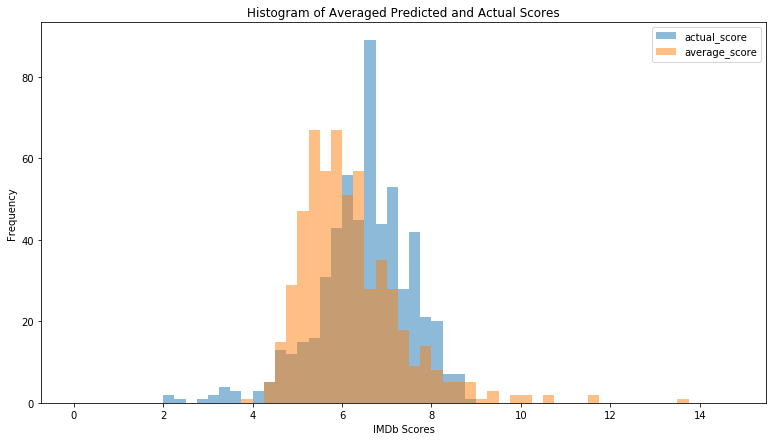

In [18]:
# Visualize the distribution of actual scores and averaged predicted scores using histograms
plot_cols = ['actual_score', 'average_score']
plt.clf();
plt.figure(figsize = (13, 7));
hist_bins = np.arange(0,15, step = 0.25)

plt.hist(master_df[plot_cols[0]], bins = hist_bins, alpha = 0.5, label=plot_cols[0])
plt.hist(master_df[plot_cols[1]], bins = hist_bins, alpha = 0.5, label=plot_cols[1])
plt.xlabel('IMDb Scores');
plt.ylabel('Frequency');
plt.legend(loc='upper right');
plt.title('Histogram of Averaged Predicted and Actual Scores');
plt.show()

From a visual inspection of the two distributions, it seems that the averaged predicted IMDb scores have been shifted to the left from the actual scores. This can be confirmed by looking at the means and standard deviations of the two distributions.

In [19]:
# Find the averages and standard deviations of the two distributions
actual_mean = master_df.actual_score.mean(axis=0)
actual_std = master_df.actual_score.std(axis=0)
print 'The mean of the actual IMDb scores is:', actual_mean
print 'The standard deviation of the actual IMDb scores is: %.4f\n' % actual_std

predict_mean = master_df.average_score.mean(axis=0)
predict_std = master_df.average_score.std(axis=0)
print 'The mean of the actual IMDb scores is:', predict_mean
print 'The standard deviation of the actual IMDb scores is: %.4f' % predict_std

The mean of the actual IMDb scores is: 6.472695035460993
The standard deviation of the actual IMDb scores is: 1.0580

The mean of the actual IMDb scores is: 6.19816258749409
The standard deviation of the actual IMDb scores is: 1.1391


### A Short Commentary 1
Looking at the overlaid histograms shown above, a couple of interesting observations can be made:
* The two distributions appear to be mirrored about each other 
    * The outliers for the **average_score** distribution lie on the right-hand side of the plot
    * The outliers for the **actual_score** distribution lie on the left-hand side of the plot
* There is a sizable overlap between the two distributions 

In many applications of statistics, outliers may be discarded from a distribution for the purpose of removing samples that deviate from the behavior of the "model" at hand. However, the outliers shown in the histogram above cannot be discarded for this reason because they are artifacts of either the raw data or the behavior of the neural network itself. As such, it makes no sense to discard outliers in this context.

However, it may be useful to conduct some hypothesis testing to see how close these distributions are to each other. Of course, a major assumption that needs to be made is that these two distributions are closely approximated by Gaussian distributions. To this end, the two hypothesis are:
* Null hypothesis: These two distributions are essentially the same (they have the same ***mean***)
* Alternate hypothesis: These two distributions are different to a statistically significant degree

For this analysis, we will assume a significance level of 0.05.

In [20]:
# Assuming these distributions have the same mean, the two subtracted distributions have:
# Mean = 0
# Standard deviation:
composite_std_raw = np.sqrt(np.power(actual_std, 2) + np.power(predict_std, 2))
# Z-score:
composite_z_raw = (predict_mean - actual_mean) / composite_std_raw

In [21]:
# Find the p-value 
import scipy.stats as st
p_val = st.norm.cdf(composite_z_raw)
print 'The p-value corresponding to the null hypothesis is %.4f' % p_val

The p-value corresponding to the null hypothesis is 0.4299


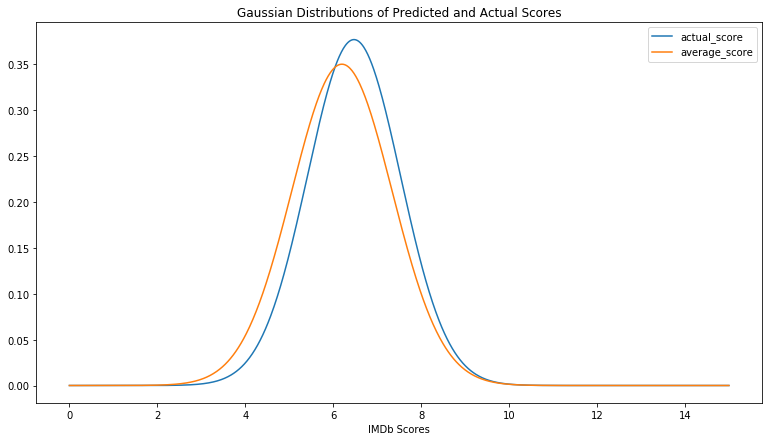

In [22]:
# Using the mean and standard deviations,, we can proceed to plot the normal distributions of the data
x = np.linspace(0, 15, 1000)
plt.clf();
plt.figure(figsize = (13, 7));
plt.plot(x, gauss(x, actual_mean, actual_std), label='actual_score')
plt.plot(x, gauss(x, predict_mean, predict_std), label='average_score')
plt.legend(loc='upper right');
plt.xlabel('IMDb Scores');
plt.title('Gaussian Distributions of Predicted and Actual Scores');

Since this p-value does not fall below the significance threshold of 0.05, it appears that accepting the null hypothesis is statistically grounded. Indeed, looking at the Gaussian plots of the two distributions above, it does appear that **they are are strikingly close**. What this means is that the statistical difference between two distributions could have occurred by chance. Removing outliers would bring these two distributions even closer together which is yet another reason why it wouldn't make any sense to do so. 

## Visualization and Statistical Analysis: Phase 2
Now that we've seen that there is a close resemblance between the two distributions, let's assess the accuracy of the averaged model and assess how it deviates from the actual IMDb scores. We've already calculated the percent change of the predicted scores to the actual scores. 

Let's visualize the distributions of percent change first.

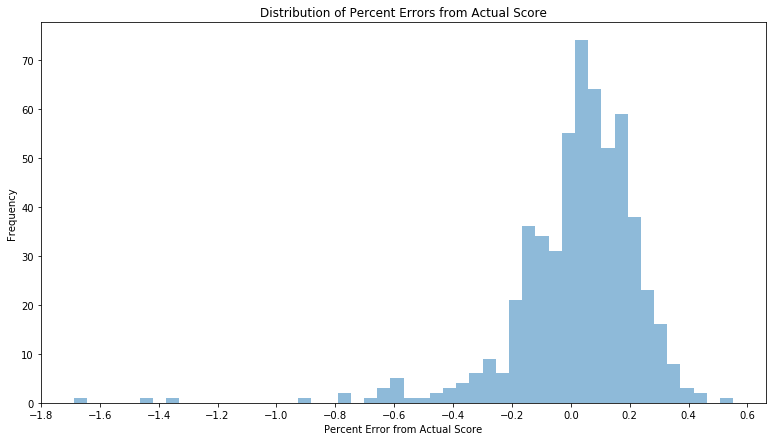

In [23]:
# Visualize the distribution of percent changes
plt.clf();
plt.figure(figsize = (13, 7));
master_df.percent_error.hist(alpha=0.5, bins=50, grid=False)
plt.xticks(np.arange(-1.8, 0.7, step = 0.2));
plt.title('Distribution of Percent Errors from Actual Score');
plt.xlabel('Percent Error from Actual Score');
plt.ylabel('Frequency');
plt.show()

Looking at the distribution of percent error values, we see that there are clear outliers in this plot. To assess the root cause behind the shortcomings of my neural network, let's zone in on outliers. Here, we will look at all percent error values that exceed 1 standard deviation. 

In [24]:
# Find average and standard deviation for percent error distribution 
pe_mean = master_df.percent_error.mean(axis=0)
pe_std = master_df.percent_error.std(axis=0)
print 'Mean of percent error distribution is %.4f' % pe_mean
print 'Standard deviation (68.27%% confidence) of percent error distribution is %.4f' % pe_std
print '2x standard deviation (95.45%% confidence) is %4f\n' % (pe_std * 2)

Mean of percent error distribution is 0.0212
Standard deviation (68.27% confidence) of percent error distribution is 0.2199
2x standard deviation (95.45% confidence) is 0.439827



### A Short Commentary 2
Now that we know the mean and standard deviation of the percent error distribution, we can begin to develop an idea of how "robust" my multilayer perceptron is in terms of confidence level. We can expect:
* An average prediction performance of 2.12%
* 68.27% of the time, we can expect to get between 24.1% to -19.9% prediction accuracy
* 95.45% of the time, we can expect to get between 46.1% to -41.9% prediction accuracy

At this moment, it cannot be said that we get stellar results from this model. Even though the average performance is impressive (predictions accurate to around 2%), we have a wide spread in predictions. Essentially, we can only comfortably rely on this model (with 95% confidence) to give us a prediction accurate to roughly 40% of the actual IMDb score.

Let's proceed to take a look at the factors influencing this behavior. We can look at characteristics of the movies that predicted unfavorably. 

In [25]:
# Find the rows of the master dataframe that have a percent error beyond 1 standard deviation
pe_high_std = pe_mean + pe_std
pe_low_std = pe_mean - pe_std
dev_high = master_df[(master_df['percent_error'] > pe_high_std)]
dev_low = master_df[(master_df['percent_error'] < pe_low_std)]
dev_list = [dev_high, dev_low]
dev_composite = pd.concat(dev_list)

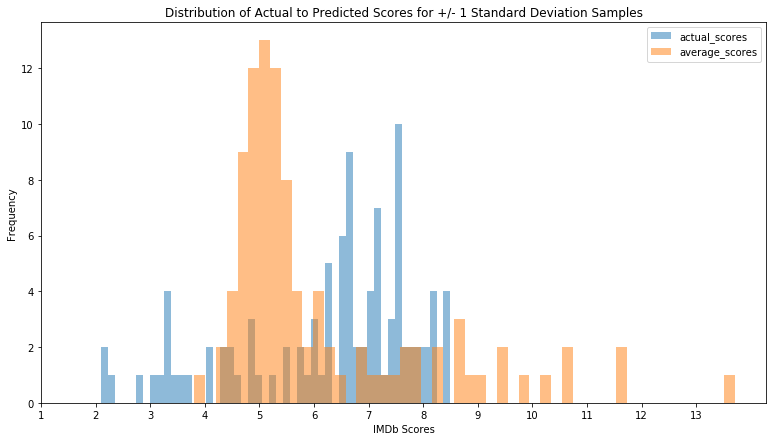

In [26]:
# Visualize the scores for the movies that had prediction errors beyond 1 standard deviation
plt.clf();
plt.figure(figsize=(13, 7));
dev_composite.actual_score.hist(alpha=0.5, bins=50, grid=False, label='actual_scores')
dev_composite.average_score.hist(alpha=0.5, bins=50, grid=False, label='average_scores')
plt.xticks(np.arange(1, 14, step=1));
plt.legend(loc='upper right');
plt.xlabel('IMDb Scores');
plt.ylabel('Frequency');
plt.title('Distribution of Actual to Predicted Scores for +/- 1 Standard Deviation Samples');

### A Shocking Insight!
A single glance at these overlaid scores (taken from a subset of the overall test data predictions) reveals a shocking similarity to the distributions of the overall test data predictions themselves. Once again, the **average_scores** distribution finds itself with a peak biased to the left-hand side of the **actual_scores** distribution. This time, however, it becomes much clearer that **there exists a separation between the behavior of the model's predictions and the raw data itself**. 

***This separation in behavior is a left-tending bias that is revealed with greater clarify after focusing on samples that deviate by more than 1 standard deviation.***

Such a behavior speaks to an underlying cause within the neural network itself. The multilayer perceptron has *"learned"* to bias results in this specific way. To assess the validity of this conjecture, we need to backtrack a bit and examine the characteristic of the training data used to train the neural network model weights.

## Getting at the Root Cause
In the following section, I will proceed to load the training data indexes that defined the three separate training sets used to create the three IMDb regression models that were averaged together. Visualizing the characteristics of the training data may yield insights into the observed behavior of my neural network.

In [27]:
# Assemble the file names for training data indexes
train1_file = prediction_path + 'train1_index.pickle'
train2_file = prediction_path + 'train2_index.pickle'
train3_file = prediction_path + 'train3_index.pickle'
train_list = [train1_file, train2_file, train3_file]

In [28]:
# Load the indexdes for the training data set
train_idx = []
for train_file in train_list:
    with open(train_file, 'rb') as train_open:
        train_idx.append(pkl.load(train_open))

In [29]:
# Import training data into pandas
train_df = pd.DataFrame()
train_score_names = []
for idx, train_set in enumerate(train_idx):
    actual_score_name = 'actual_score_%s' % (idx + 1)
    train_score_names.append(actual_score_name)
    original_idx = 'original_index_%s' % (idx + 1)
    temp_train_df = movie_df.iloc[train_set]
    temp_train_df.reset_index(inplace=True)
    train_df[original_idx] = temp_train_df['index']
    train_df[actual_score_name] = temp_train_df.imdb_score

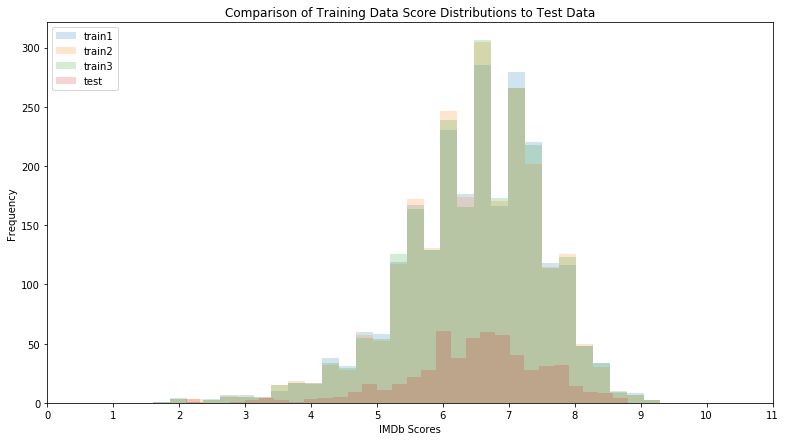

In [30]:
# Visualize the distributions of IMDb scores for the 3 training sets
plt.clf();
trans_val = 0.2
tbin_num = 30
plt.figure(figsize=(13, 7));
train_df.actual_score_1.hist(alpha=trans_val, bins=tbin_num, grid=False, label='train1')
train_df.actual_score_2.hist(alpha=trans_val, bins=tbin_num, grid=False, label='train2')
train_df.actual_score_3.hist(alpha=trans_val, bins=tbin_num, grid=False, label='train3')
meta_df.imdb_score.hist(alpha=trans_val, bins=tbin_num, grid=False, label='test')
plt.legend(loc='upper left');
plt.xlabel('IMDb Scores');
plt.ylabel('Frequency');
plt.xticks(np.arange(0, 12, step=1));
plt.title('Comparison of Training Data Score Distributions to Test Data');

### A Short Commentary 3
From the plot above, it can be seen that there might exist a discrepancy between the distribution characteristics of the training sets and the testing set. We already know the mean IMDb score and standard deviations of the testing set distribution. Let's take a look at the mean scores and standard deviations for the training set distribution.

In [31]:
training_means = []
training_std = []
for name in train_score_names:
    training_means.append(train_df[name].mean(axis=0))
    training_std.append(train_df[name].std(axis=0))
avg_train_mean = np.average(training_means)
avg_train_std = np.average(training_std)
print 'Average mean score for training sets is %.4f' % avg_train_mean
print 'Average standard deviation for training sets is %.4f' % avg_train_std

Average mean score for training sets is 6.4586
Average standard deviation for training sets is 1.0636


To get a better idea of the differences between the training sets' distributions and the the test set distribution, let's plot some Gaussians visually assess the similarities and differences between the test and training sets:

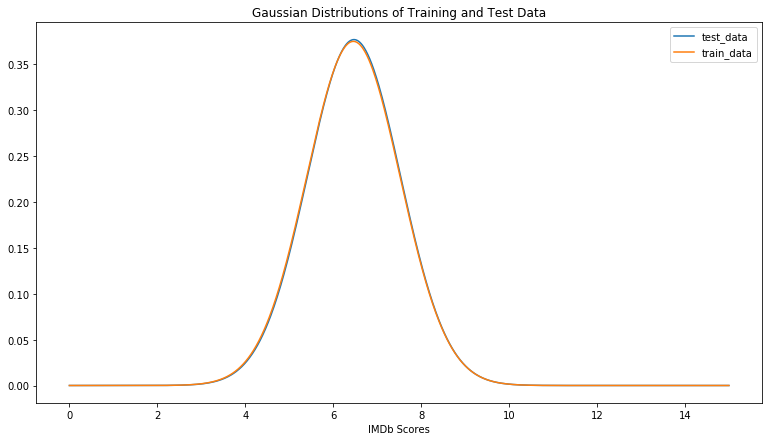

In [32]:
# Plot Gaussians to compare training and test sets
x = np.linspace(0, 15, 1000)
plt.clf();
plt.figure(figsize = (13, 7));
plt.plot(x, gauss(x, actual_mean, actual_std), label='test_data')
plt.plot(x, gauss(x, avg_train_mean, avg_train_std), label='train_data')
plt.legend(loc='upper right');
plt.xlabel('IMDb Scores');
plt.title('Gaussian Distributions of Training and Test Data');

From the plot of these two Gaussian representations of the training and test set distributions, we can visually confirm that they are essentially the same distributions. This clarifies the slightly muddled visualization of the overlaid four-distribution histogram above. This result comes as a relief since it means that the sampling used to generate the three training sets and the one testing set was consistent. ***This visualization rules out sampling mistakes as the cause of the observed bias in the neural network***.

## One Final Crack at the Mystery & Concluding Remarks
If a sampling error wasn't the culprit, this opens the door to the possibility that a systemic issue might exist. This means that an underlying mechanism within the deep neural network is applying a bias. To assess this, I will proceed to visualize the results of the three IMDb regression models to evaluate whether or not they are consistent with each other. A consistent behavior amongst the three models will support the presence of a systemic issue.

In this final section, I will look at the behaviors of each individual IMDb regression model compared against the raw test data score distribution. 

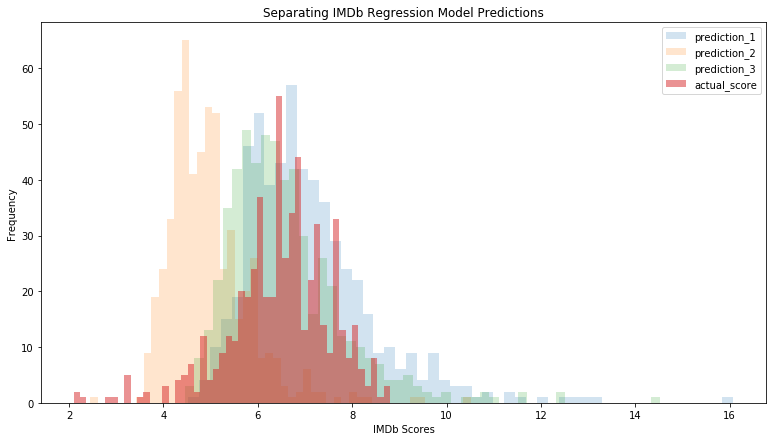

In [33]:
# Plot the individual IMDb regression model results and along with the actual scores
imdb_bins = 50
plt.clf();
plt.figure(figsize=(13, 7));
master_df.prediction_1.hist(alpha=trans_val, bins=imdb_bins, grid=False, label='prediction_1')
master_df.prediction_2.hist(alpha=trans_val, bins=imdb_bins, grid=False, label='prediction_2')
master_df.prediction_3.hist(alpha=trans_val, bins=imdb_bins, grid=False, label='prediction_3')
master_df.actual_score.hist(alpha=0.5, bins=imdb_bins, grid=False, label='actual_score')
plt.legend(loc='upper right');
plt.xlabel('IMDb Scores');
plt.ylabel('Frequency');
plt.title('Separating IMDb Regression Model Predictions');

From the overlaid histogram plots shown above, a significant clue behind the mystery of the neural network's behavior is revealed. It can be seen that the weights generated for the second training set deviates quite signifiantly from the other three distributions. Since **prediction_1** and **prediction_3** appear to be well-centered around the **actual_score** distribution, we see that there isn't a consistent behavior in the neural network that is responsible for the overall bias in the prediction scores. 

Therefore, if we were to train the neural network again, we can expect that a different result than the one observed for this training set will be produced. If we were to deploy the results of this neural network, choosing the weight files from *training set 1* and *training set 3* appear to make the most sense as they are the ones most closely centered about the *actual score*. 

## A Final Word
The performance of this neural network can definitely be improved-upon. A few ideas off the top of my head are:
* Deepening the multilayer perceptron that I used 
* Including more fields for the neural network to process
* Running the neural network for more epochs 
    * Current epoch count is 3 for every training stage 
* Upsampling data that is under-represented (i.e. movies at the low and high-end of the IMDb score spectrum)
* Using more training sets (I only had 3 in this case)

Well, we've come to the end of this IMDb project and analysis! Thank you very much for reading through my first independent software engineering / data science project ever! I'll endeavor to push more out in the coming months / years!

***Completion Date: March 31, 2018***